In [8]:
import torch, os, timm, random, time
import torchvision
import numpy as np
import pandas as pf
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob
from tqdm import tqdm
def random_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)
random_seed(42)

In [9]:

class CustomDataset(Dataset):
    def __init__(self, root, data_type='train', transformations=None):
        super().__init__()
        self.transformations = transformations
        self.data = glob(f"{root}/{data_type}/*.jpeg")
        
        # Initialize all attributes
        self.im_path = []
        self.label = []
        self.class_names = {}
        self.class_count = {}
        
        if "train" in data_type:
            class_ID = 0
            for path in self.data:
                class_name = self.get_class_name(path)
                if class_name not in self.class_names:
                    self.class_names[class_name] = class_ID
                    class_ID += 1
                    self.class_count[class_name] = 0
                self.class_count[class_name] += 1
                
                # Add to lists
                self.im_path.append(path)
                self.label.append(self.class_names[class_name])
        else:
            class_ID = 0
            for path in self.data:
                class_name = self.get_class_name(path)
                if class_name not in self.class_names:
                    self.class_names[class_name] = class_ID
                    class_ID += 1
                    self.class_count[class_name] = 0
                
                self.class_count[class_name] += 1
                self.im_path.append(path)
                self.label.append(self.class_names[class_name])
    
    def get_class_name(self, path):
        return os.path.basename(path).split(".")[0].split('_')[-1]
    
    def __len__(self):
        return len(self.im_path)
    
    def __getitem__(self, idx):
        im_path = self.im_path[idx]
        label = self.label[idx]
        im = Image.open(im_path).convert("RGB")
        
        if self.transformations:
            import numpy as np
            im_array = np.array(im)
            transformed = self.transformations(image=im_array)
            im = transformed['image']
        
        return im, label  

def get_dl(root, tr_transformation, ts_transformation, bs, splt=[0.9, 0.1]):
    tr_ds = CustomDataset(root=root, data_type="retina-train", transformations=tr_transformation)
    ts_ds = CustomDataset(root=root, data_type="retina-test", transformations=ts_transformation)
    
    cls_name, cls_count = tr_ds.class_names, tr_ds.class_count
    all_data = len(tr_ds)
    tr_len = int(all_data * splt[0])
    val_len = all_data - tr_len
    
    tr_dataset, val_dataset = random_split(tr_ds, lengths=[tr_len, val_len])
    
    tr_dl = DataLoader(tr_dataset, batch_size=bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(val_dataset, batch_size=bs, shuffle=True, num_workers=0)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=0)
    
    return tr_dl, val_dl, ts_dl, cls_name, cls_count  # Fixed: was ts_ds, now ts_dl

def get_advanced_transforms(img_size=224, is_training=True):
    if is_training:
        return A.Compose([
            A.Resize(img_size, img_size),
            
            # Geometric transformations
            A.RandomRotate90(p=0.5),
            A.Rotate(limit=30, p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.7),
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
            # Color/brightness augmentations
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),
            
            # Noise and blur - Fixed parameters
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Fixed: removed mean parameter
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.MotionBlur(blur_limit=3, p=0.1),
            
            # Cutout/dropout - Fixed parameters for newer albumentations
            A.CoarseDropout(
                num_holes_range=(1, 8), 
                hole_height_range=(8, 16), 
                hole_width_range=(8, 16),
                fill_value=0, 
                p=0.2
            ),
            
            # Normalization
            A.Normalize(mean=[0.4321, 0.3665, 0.3147], std=[0.3112, 0.2556, 0.2168]),
          
            
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.4321, 0.3665, 0.3147], std=[0.3112, 0.2556, 0.2168]),
            ToTensorV2(),
        ])

# Usage
root = "data"
tr_trs = get_advanced_transforms(img_size=224, is_training=True) 
ts_trs = get_advanced_transforms(img_size=224, is_training=False) 

tr_dl, val_dl, ts_dl, classes, cls_counts = get_dl(
    root=root, 
    tr_transformation=tr_trs, 
    ts_transformation=ts_trs, 
    bs=32
)

print(len(tr_dl))
print(len(val_dl)) 
print(len(ts_dl))

59
7
522


/tmp/ipykernel_359514/226868098.py:95: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Fixed: removed mean parameter
/tmp/ipykernel_359514/226868098.py:100: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [10]:
def tr_2_im(t, type = "rgb"):
    gray = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [1/0.3112, 1/0.2556, 1/0.2168]),
                         T.Normalize(mean = [-0.4321, -0.3665, -0.3147], std = [ 1., 1., 1. ])])
    inp = gray if type =="gray" else rgb
    return(inp(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if type == "gray" else (inp(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def Visualize(data, rows, num_imgs, cmap = None, class_names = None):
    index = [random.randint(0, len(data)-1) for _ in range(num_imgs)]
    plt.figure(figsize=(20, 16))
    for i, idx in enumerate(index):
        im, gt = data[idx]
        plt.subplot(rows, num_imgs//rows, i+1)
        plt.imshow(tr_2_im(im, cmap), cmap = "RdBu")
        plt.imshow(tr_2_im(im))
        plt.title(f" GT -> {class_names[gt]}")
        plt.axis("off")
    

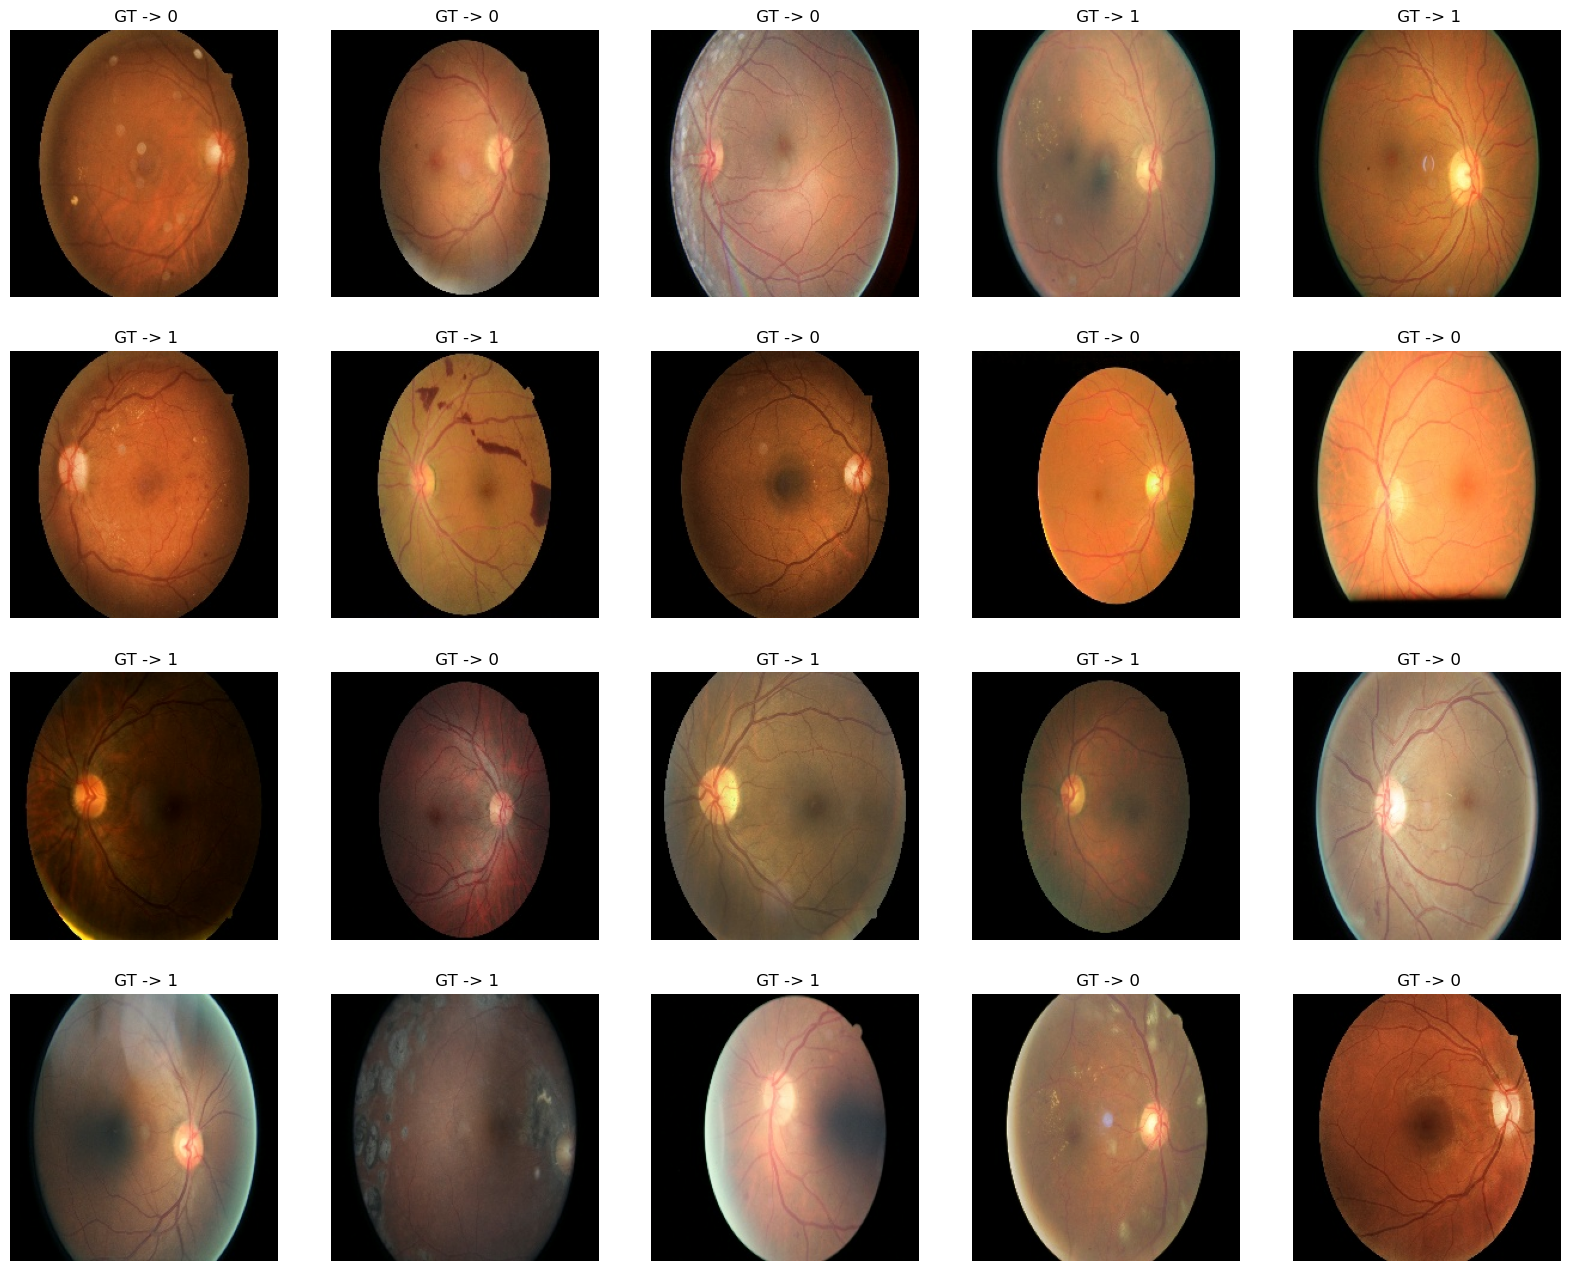

In [11]:
Visualize(data = ts_dl.dataset, rows = 4, num_imgs=20, class_names = list(classes.keys()))

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import numpy as np

def analyze_dataset(root, tr_dl, val_dl, ts_dl, classes, cls_counts):
    # Create output directory for visualizations
    os.makedirs("data_analysis", exist_ok=True)
    
    # 1. Class Distribution Analysis
    def plot_class_distribution(cls_counts, title="Class Distribution"):
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(cls_counts.keys()), y=list(cls_counts.values()))
        plt.title(title)
        plt.xlabel("Classes")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

analyze_dataset(root, tr_dl, val_dl, ts_dl, classes, cls_counts)

In [12]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef
from tqdm import tqdm
import timm
import pickle
import time
import torch
import os
import numpy as np

def random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

def tic_toc(start_time=None):
    return time.time() if start_time is None else time.time() - start_time

def train(model, tr_dl, val_dl, loss_fn, opt, scheduler, device, epochs, save, threshold):
    # Train metrics
    tr_acc_sc = []
    tr_loss_sc = []
    tr_f1_sc = []
    tr_auc_sc = []
    tr_mcc_sc = []
    # Validation metrics
    val_acc_sc = []
    val_loss_sc = []
    val_f1_sc = []
    val_auc_sc = []
    val_mcc_sc = []

    best_loss = np.inf
    train_start = tic_toc()
    save_dir = "best_model"
    not_improved, patience = 0, 10
    os.makedirs(save_dir,exist_ok=True)

    for epoch in range(epochs):
        tic = tic_toc()
        print(f"{epoch+1} - Train is starting ...")
        model.train()
        tr_epoch_loss, tr_epoch_acc = 0, 0
        tr_probs, tr_labels, tr_preds = [], [], []

        for idx, batch in enumerate(tqdm(tr_dl)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            loss = loss_fn(pred, gt)
            tr_epoch_loss += loss.item()

            pred_classes = torch.argmax(pred, dim=1)
            tr_epoch_acc += (pred_classes == gt).sum().item()

            tr_probs.extend(torch.softmax(pred, dim=1).detach().cpu().numpy())
            tr_labels.extend(gt.cpu().numpy())
            tr_preds.extend(pred_classes.cpu().numpy())

            opt.zero_grad()
            loss.backward()
            opt.step() 

        tr_epoch_acc /= len(tr_dl.dataset)
        tr_epoch_loss /= len(tr_dl)

        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class="ovo")
        f1_sc = f1_score(tr_labels, tr_preds, average='weighted')
        tr_mcc = matthews_corrcoef(tr_labels, tr_preds)

        tr_acc_sc.append(tr_epoch_acc) 
        tr_loss_sc.append(tr_epoch_loss)
        tr_f1_sc.append(f1_sc)
        tr_auc_sc.append(tr_auc)
        tr_mcc_sc.append(tr_mcc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc = 0, 0
            val_probs, val_labels, val_preds = [], [], []
            for idx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred1 = model(im)
                pred2 = model(im.flip(-1))
                pred3 = model(im.flip(-2))
                pred4 = model(im.flip([-2,-1]))
                pred5 = model(im.flip(-1).flip([-2,-1]))
                pred6 = model(im.flip(-2).flip([-2, -1]))
                pred = (pred1 + pred2+pred3+pred4+pred5+pred6)/6
                loss = loss_fn(pred, gt)
                
                val_epoch_loss += loss.item()
                pred_class = torch.argmax(pred, dim=1)
                val_epoch_acc += (pred_class == gt).sum().item()
                
                val_probs.extend(torch.softmax(pred, dim=1).detach().cpu().numpy())
                val_labels.extend(gt.cpu().numpy())
                val_preds.extend(pred_class.cpu().numpy())

            val_epoch_acc /= len(val_dl.dataset)
            val_epoch_loss /= len(val_dl)

            val_auc = roc_auc_score(val_labels, val_probs, multi_class="ovo")
            vf1_sc = f1_score(val_labels, val_preds, average='weighted')
            val_mcc = matthews_corrcoef(val_labels, val_preds)
            
            val_acc_sc.append(val_epoch_acc)
            val_loss_sc.append(val_epoch_loss)
            val_f1_sc.append(vf1_sc)
            val_auc_sc.append(val_auc) 
            val_mcc_sc.append(val_mcc)

            print(f"{epoch + 1} - Epoch Train process results:")
            print(f" Training time -> {tic_toc(tic):.3f} sec")
            print(f"{epoch + 1} - Epoch Train Accuracy score       -> {tr_epoch_acc:.3f}")
            print(f"{epoch + 1} - Epoch Train Loss score           -> {tr_epoch_loss:.3f}")
            print(f"{epoch + 1} - Epoch Train AUC                  -> {tr_auc:.3f}")
            print(f"{epoch + 1} - Epoch Train MCC                  -> {tr_mcc:.3f}")
            print(f"{epoch + 1} - Epoch Train F1                   -> {f1_sc:.3f}")
            print(f"{epoch + 1} - Epoch Validation process results:")
            print(f"{epoch + 1} - Epoch Validation Accuracy score  -> {val_epoch_acc:.3f}")
            print(f"{epoch + 1} - Epoch Validation Loss score      -> {val_epoch_loss:.3f}") 
            print(f"{epoch + 1} - Epoch Validation AUC             -> {val_auc:.3f}")
            print(f"{epoch + 1} - Epoch Validation MCC             -> {val_mcc:.3f}")
            print(f"{epoch + 1} - Epoch Validation F1              -> {vf1_sc:.3f}")

        
            if val_epoch_loss < (best_loss + threshold):
                best_loss = val_epoch_loss
                not_improved = 0
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), f"{save_dir}/{save}_best_model.pth")
                print(f"{epoch + 1} - SAVED: {save_dir}/{save}_best_model.pth")
      
    return {
        "tr_loss_acc": tr_loss_sc, "tr_acc_sc": tr_acc_sc, "tr_auc_sc": tr_auc_sc, "tr_f1_sc": tr_f1_sc, "tr_mcc_sc": tr_mcc_sc,
        "val_loss_acc": val_loss_sc, "val_acc_sc": val_acc_sc, "val_auc_sc": val_auc_sc, "val_f1_sc": val_f1_sc, "val_mcc_sc": val_mcc_sc
    }

In [15]:
import torch.nn.functional as F
import torch.nn as nn 
random_seed(42)
device = "cuda"if torch.cuda.is_available() else "cpu"
model = timm.create_model("skresnext50_32x4d", pretrained= True,  num_classes = len(classes))
# model = timm.create_model("rexnet_150", pretrained= True,  num_classes = len(classes))
print(device)

model.to(device)
loss_fn = nn.CrossEntropyLoss()
# loss_fn= FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


result = train(
        model = model,
        tr_dl = tr_dl,
        val_dl = val_dl,
        loss_fn = loss_fn,
        opt = optimizer,
        scheduler = scheduler,
        device = device,
        epochs = 20,
        save = "all_diabetic",
        threshold = 0.0001)

cuda
1 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


1 - Epoch Train process results:
 Training time -> 146.351 sec
1 - Epoch Train Accuracy score       -> 0.571
1 - Epoch Train Loss score           -> 0.924
1 - Epoch Train AUC                  -> 0.616
1 - Epoch Train MCC                  -> 0.091
1 - Epoch Train F1                   -> 0.487
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  -> 0.627
1 - Epoch Validation Loss score      -> 0.852
1 - Epoch Validation AUC             -> 0.716
1 - Epoch Validation MCC             -> 0.323
1 - Epoch Validation F1              -> 0.527
1 - SAVED: best_model/all_diabetic_best_model.pth
2 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.91s/it]


2 - Epoch Train process results:
 Training time -> 144.716 sec
2 - Epoch Train Accuracy score       -> 0.629
2 - Epoch Train Loss score           -> 0.841
2 - Epoch Train AUC                  -> 0.715
2 - Epoch Train MCC                  -> 0.272
2 - Epoch Train F1                   -> 0.567
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  -> 0.622
2 - Epoch Validation Loss score      -> 0.856
2 - Epoch Validation AUC             -> 0.716
2 - Epoch Validation MCC             -> 0.299
2 - Epoch Validation F1              -> 0.533
3 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


3 - Epoch Train process results:
 Training time -> 144.871 sec
3 - Epoch Train Accuracy score       -> 0.639
3 - Epoch Train Loss score           -> 0.803
3 - Epoch Train AUC                  -> 0.729
3 - Epoch Train MCC                  -> 0.301
3 - Epoch Train F1                   -> 0.573
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  -> 0.612
3 - Epoch Validation Loss score      -> 0.843
3 - Epoch Validation AUC             -> 0.736
3 - Epoch Validation MCC             -> 0.275
3 - Epoch Validation F1              -> 0.550
3 - SAVED: best_model/all_diabetic_best_model.pth
4 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


4 - Epoch Train process results:
 Training time -> 144.974 sec
4 - Epoch Train Accuracy score       -> 0.658
4 - Epoch Train Loss score           -> 0.782
4 - Epoch Train AUC                  -> 0.753
4 - Epoch Train MCC                  -> 0.342
4 - Epoch Train F1                   -> 0.617
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  -> 0.694
4 - Epoch Validation Loss score      -> 0.785
4 - Epoch Validation AUC             -> 0.787
4 - Epoch Validation MCC             -> 0.445
4 - Epoch Validation F1              -> 0.665
4 - SAVED: best_model/all_diabetic_best_model.pth
5 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.88s/it]


5 - Epoch Train process results:
 Training time -> 143.939 sec
5 - Epoch Train Accuracy score       -> 0.667
5 - Epoch Train Loss score           -> 0.738
5 - Epoch Train AUC                  -> 0.779
5 - Epoch Train MCC                  -> 0.365
5 - Epoch Train F1                   -> 0.627
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  -> 0.560
5 - Epoch Validation Loss score      -> 0.989
5 - Epoch Validation AUC             -> 0.728
5 - Epoch Validation MCC             -> 0.271
5 - Epoch Validation F1              -> 0.564
6 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


6 - Epoch Train process results:
 Training time -> 144.727 sec
6 - Epoch Train Accuracy score       -> 0.679
6 - Epoch Train Loss score           -> 0.726
6 - Epoch Train AUC                  -> 0.788
6 - Epoch Train MCC                  -> 0.389
6 - Epoch Train F1                   -> 0.643
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  -> 0.699
6 - Epoch Validation Loss score      -> 0.776
6 - Epoch Validation AUC             -> 0.781
6 - Epoch Validation MCC             -> 0.457
6 - Epoch Validation F1              -> 0.670
6 - SAVED: best_model/all_diabetic_best_model.pth
7 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


7 - Epoch Train process results:
 Training time -> 144.669 sec
7 - Epoch Train Accuracy score       -> 0.677
7 - Epoch Train Loss score           -> 0.724
7 - Epoch Train AUC                  -> 0.791
7 - Epoch Train MCC                  -> 0.383
7 - Epoch Train F1                   -> 0.645
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  -> 0.665
7 - Epoch Validation Loss score      -> 0.730
7 - Epoch Validation AUC             -> 0.793
7 - Epoch Validation MCC             -> 0.387
7 - Epoch Validation F1              -> 0.622
7 - SAVED: best_model/all_diabetic_best_model.pth
8 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


8 - Epoch Train process results:
 Training time -> 144.992 sec
8 - Epoch Train Accuracy score       -> 0.693
8 - Epoch Train Loss score           -> 0.709
8 - Epoch Train AUC                  -> 0.801
8 - Epoch Train MCC                  -> 0.417
8 - Epoch Train F1                   -> 0.664
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  -> 0.684
8 - Epoch Validation Loss score      -> 0.742
8 - Epoch Validation AUC             -> 0.791
8 - Epoch Validation MCC             -> 0.431
8 - Epoch Validation F1              -> 0.650
9 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


9 - Epoch Train process results:
 Training time -> 144.805 sec
9 - Epoch Train Accuracy score       -> 0.708
9 - Epoch Train Loss score           -> 0.674
9 - Epoch Train AUC                  -> 0.823
9 - Epoch Train MCC                  -> 0.453
9 - Epoch Train F1                   -> 0.683
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  -> 0.699
9 - Epoch Validation Loss score      -> 0.721
9 - Epoch Validation AUC             -> 0.813
9 - Epoch Validation MCC             -> 0.457
9 - Epoch Validation F1              -> 0.675
9 - SAVED: best_model/all_diabetic_best_model.pth
10 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


10 - Epoch Train process results:
 Training time -> 144.824 sec
10 - Epoch Train Accuracy score       -> 0.710
10 - Epoch Train Loss score           -> 0.664
10 - Epoch Train AUC                  -> 0.825
10 - Epoch Train MCC                  -> 0.454
10 - Epoch Train F1                   -> 0.681
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  -> 0.684
10 - Epoch Validation Loss score      -> 0.729
10 - Epoch Validation AUC             -> 0.800
10 - Epoch Validation MCC             -> 0.428
10 - Epoch Validation F1              -> 0.667
11 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.91s/it]


11 - Epoch Train process results:
 Training time -> 144.895 sec
11 - Epoch Train Accuracy score       -> 0.719
11 - Epoch Train Loss score           -> 0.644
11 - Epoch Train AUC                  -> 0.836
11 - Epoch Train MCC                  -> 0.472
11 - Epoch Train F1                   -> 0.698
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  -> 0.737
11 - Epoch Validation Loss score      -> 0.668
11 - Epoch Validation AUC             -> 0.853
11 - Epoch Validation MCC             -> 0.536
11 - Epoch Validation F1              -> 0.716
11 - SAVED: best_model/all_diabetic_best_model.pth
12 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


12 - Epoch Train process results:
 Training time -> 144.719 sec
12 - Epoch Train Accuracy score       -> 0.723
12 - Epoch Train Loss score           -> 0.656
12 - Epoch Train AUC                  -> 0.836
12 - Epoch Train MCC                  -> 0.482
12 - Epoch Train F1                   -> 0.702
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  -> 0.737
12 - Epoch Validation Loss score      -> 0.615
12 - Epoch Validation AUC             -> 0.868
12 - Epoch Validation MCC             -> 0.538
12 - Epoch Validation F1              -> 0.711
12 - SAVED: best_model/all_diabetic_best_model.pth
13 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


13 - Epoch Train process results:
 Training time -> 144.742 sec
13 - Epoch Train Accuracy score       -> 0.722
13 - Epoch Train Loss score           -> 0.628
13 - Epoch Train AUC                  -> 0.844
13 - Epoch Train MCC                  -> 0.478
13 - Epoch Train F1                   -> 0.699
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  -> 0.756
13 - Epoch Validation Loss score      -> 0.667
13 - Epoch Validation AUC             -> 0.832
13 - Epoch Validation MCC             -> 0.569
13 - Epoch Validation F1              -> 0.735
14 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


14 - Epoch Train process results:
 Training time -> 144.219 sec
14 - Epoch Train Accuracy score       -> 0.730
14 - Epoch Train Loss score           -> 0.617
14 - Epoch Train AUC                  -> 0.852
14 - Epoch Train MCC                  -> 0.495
14 - Epoch Train F1                   -> 0.711
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  -> 0.708
14 - Epoch Validation Loss score      -> 0.739
14 - Epoch Validation AUC             -> 0.805
14 - Epoch Validation MCC             -> 0.475
14 - Epoch Validation F1              -> 0.682
15 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


15 - Epoch Train process results:
 Training time -> 144.838 sec
15 - Epoch Train Accuracy score       -> 0.767
15 - Epoch Train Loss score           -> 0.574
15 - Epoch Train AUC                  -> 0.873
15 - Epoch Train MCC                  -> 0.570
15 - Epoch Train F1                   -> 0.749
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  -> 0.675
15 - Epoch Validation Loss score      -> 0.751
15 - Epoch Validation AUC             -> 0.811
15 - Epoch Validation MCC             -> 0.421
15 - Epoch Validation F1              -> 0.668
16 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.90s/it]


16 - Epoch Train process results:
 Training time -> 144.671 sec
16 - Epoch Train Accuracy score       -> 0.746
16 - Epoch Train Loss score           -> 0.596
16 - Epoch Train AUC                  -> 0.865
16 - Epoch Train MCC                  -> 0.528
16 - Epoch Train F1                   -> 0.731
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  -> 0.694
16 - Epoch Validation Loss score      -> 0.747
16 - Epoch Validation AUC             -> 0.807
16 - Epoch Validation MCC             -> 0.446
16 - Epoch Validation F1              -> 0.671
17 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.91s/it]


17 - Epoch Train process results:
 Training time -> 144.740 sec
17 - Epoch Train Accuracy score       -> 0.761
17 - Epoch Train Loss score           -> 0.564
17 - Epoch Train AUC                  -> 0.878
17 - Epoch Train MCC                  -> 0.558
17 - Epoch Train F1                   -> 0.743
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  -> 0.727
17 - Epoch Validation Loss score      -> 0.695
17 - Epoch Validation AUC             -> 0.811
17 - Epoch Validation MCC             -> 0.510
17 - Epoch Validation F1              -> 0.716
18 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


18 - Epoch Train process results:
 Training time -> 144.833 sec
18 - Epoch Train Accuracy score       -> 0.762
18 - Epoch Train Loss score           -> 0.543
18 - Epoch Train AUC                  -> 0.888
18 - Epoch Train MCC                  -> 0.559
18 - Epoch Train F1                   -> 0.748
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  -> 0.699
18 - Epoch Validation Loss score      -> 0.715
18 - Epoch Validation AUC             -> 0.825
18 - Epoch Validation MCC             -> 0.456
18 - Epoch Validation F1              -> 0.687
19 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]


19 - Epoch Train process results:
 Training time -> 144.991 sec
19 - Epoch Train Accuracy score       -> 0.763
19 - Epoch Train Loss score           -> 0.553
19 - Epoch Train AUC                  -> 0.879
19 - Epoch Train MCC                  -> 0.562
19 - Epoch Train F1                   -> 0.747
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  -> 0.684
19 - Epoch Validation Loss score      -> 0.705
19 - Epoch Validation AUC             -> 0.820
19 - Epoch Validation MCC             -> 0.438
19 - Epoch Validation F1              -> 0.668
20 - Train is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.89s/it]

20 - Epoch Train process results:
 Training time -> 144.550 sec
20 - Epoch Train Accuracy score       -> 0.771
20 - Epoch Train Loss score           -> 0.545
20 - Epoch Train AUC                  -> 0.889
20 - Epoch Train MCC                  -> 0.578
20 - Epoch Train F1                   -> 0.759
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  -> 0.703
20 - Epoch Validation Loss score      -> 0.692
20 - Epoch Validation AUC             -> 0.838
20 - Epoch Validation MCC             -> 0.489
20 - Epoch Validation F1              -> 0.706


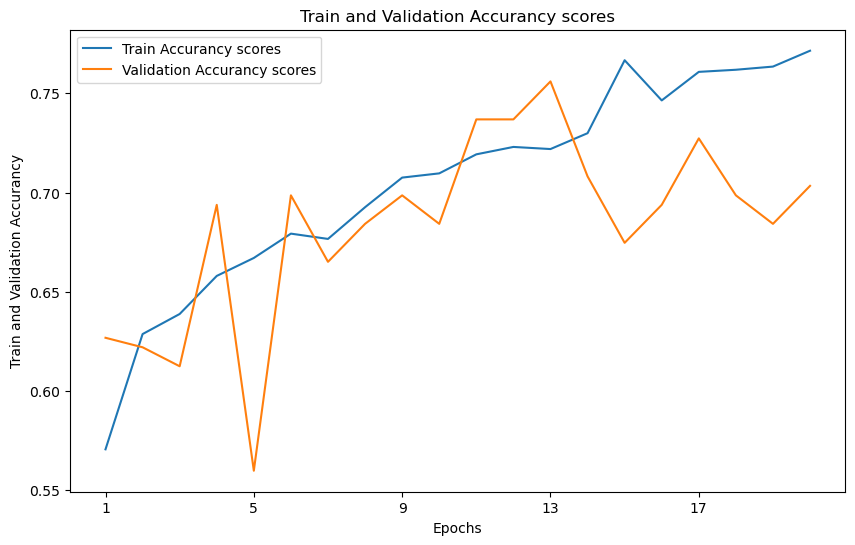

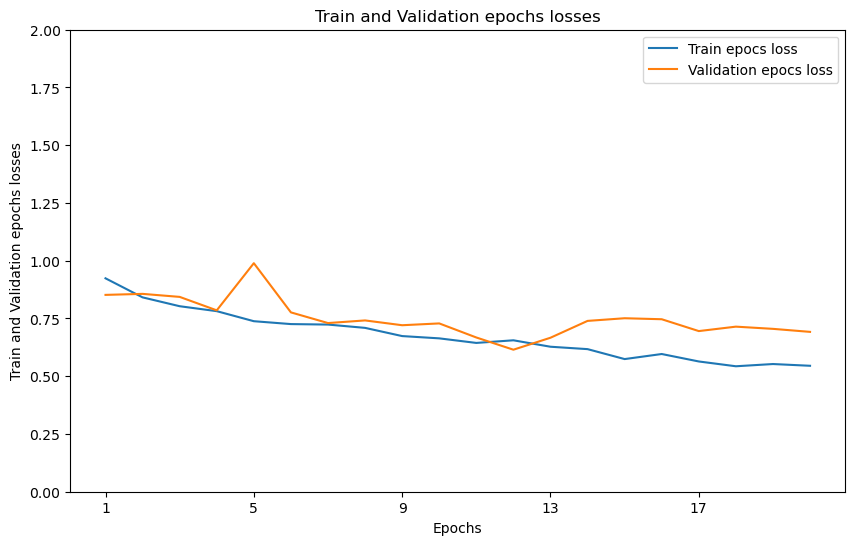

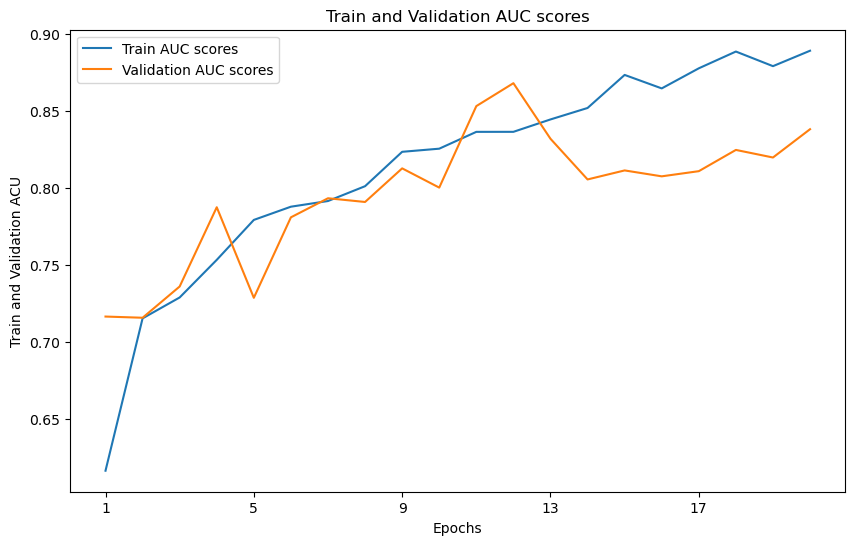

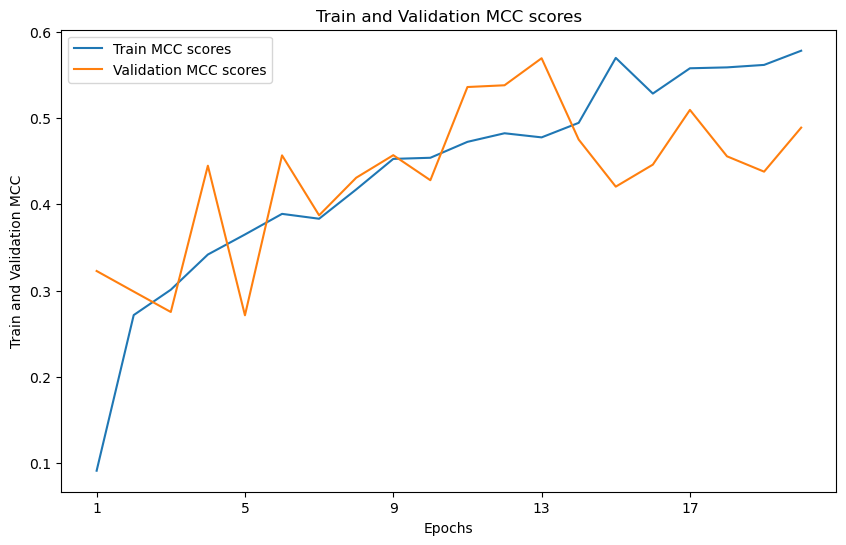

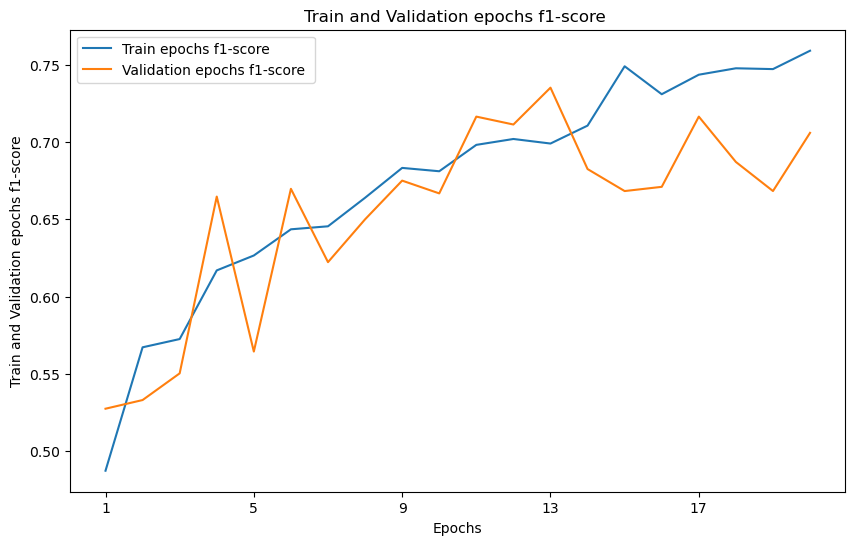

In [18]:
class plots():
    def __init__(self, r):
        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_acc_sc"], label ="Train Accurancy scores")
        plt.plot(r["val_acc_sc"], label = "Validation Accurancy scores")
        plt.title("Train and Validation Accurancy scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation Accurancy")
        plt.xticks(np.arange(0, len(r["val_acc_sc"]), 4), [i for i in range(1, len(r["val_acc_sc"])+1,4 )])
        plt.legend()
      
        
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_loss_acc"], label ="Train epocs loss")
        plt.plot(r["val_loss_acc"], label = "Validation epocs loss")
        plt.title("Train and Validation epochs losses")
        plt.xlabel("Epochs")
        plt.ylim(0, 2)
        plt.ylabel("Train and Validation epochs losses")
        plt.xticks(np.arange(0, len(r["val_loss_acc"]), 4), [i for i in range(1, len(r["val_loss_acc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_auc_sc"], label ="Train AUC scores")
        plt.plot(r["val_auc_sc"], label = "Validation AUC scores")
        plt.title("Train and Validation AUC scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation ACU")
        plt.xticks(np.arange(0, len(r["val_auc_sc"]), 4), [i for i in range(1, len(r["val_auc_sc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_mcc_sc"], label ="Train MCC scores")
        plt.plot(r["val_mcc_sc"], label = "Validation MCC scores")
        plt.title("Train and Validation MCC scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation MCC")
        plt.xticks(np.arange(0, len(r["val_auc_sc"]), 4), [i for i in range(1, len(r["val_auc_sc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_f1_sc"], label ="Train epochs f1-score")
        plt.plot(r["val_f1_sc"], label = "Validation epochs f1-score ")
        plt.title("Train and Validation epochs f1-score ")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation epochs f1-score")
        plt.xticks(np.arange(0, len(r["val_f1_sc"]), 4), [i for i in range(1, len(r["val_f1_sc"])+1, 4)])
        plt.legend()
        plt.show()

plots(result)

In [17]:
from tqdm import tqdm
import csv
import os
from datetime import datetime
import torch

save_dir = "best_model"
save = "all_diabetic"

model = timm.create_model("skresnext50_32x4d", pretrained= True,  num_classes = len(classes))
# model = timm.create_model("rexnet_150", pretrained= True,  num_classes = len(classes))

model.load_state_dict(torch.load(f"{save_dir}/{save}_best_model.pth"))
model.to(device)
model.eval()

output_file = "test_result3.csv"
if os.path.exists(output_file):
    output_file = f"test_predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

idx_to_cls = {v: k for k, v in classes.items()}

ts_ds = CustomDataset(root=root, data_type="retina-test", transformations=ts_trs)

with open(output_file, "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'Category'])
    writer.writeheader()
    
    with torch.no_grad():
        for i in tqdm(range(len(ts_ds)), desc="Predicting"):
            image, _ = ts_ds[i] 
            im_path = ts_ds.im_path[i]
            im = image.unsqueeze(0).to(device)
            pred1 = model(im)
            pred2 = model(im.flip(-1))
            pred3 = model(im.flip(-2))
            pred4 = model(im.flip([-2,-1]))
            pred5 = model(im.flip(-1).flip([-2,-1]))
            pred6 = model(im.flip(-2).flip([-2, -1]))
            pred = (pred1 + pred2+pred3+pred4+pred5+pred6)/6
            prob = torch.argmax(avg_preds, dim=1).cpu().item()
    
            pred_class = idx_to_cls[prob]
            filename = os.path.basename(im_path)
            writer.writerow({'id': filename, 'Category': pred_class})

print(f"Saved predictions to {output_file}")

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 522/522 [01:23<00:00,  6.29it/s]

Saved predictions to test_predictions_20250808_223025.csv
